# Map 2 - Unconformity

This map is also from Bennison et al. (2011). First, we import the required libraries:

In [1]:
# Import libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import geopandas as gpd
import rasterio
import gempy as gp
import gemgis as gg
from pyvistaqt import BackgroundPlotter

Then, we display the map image:

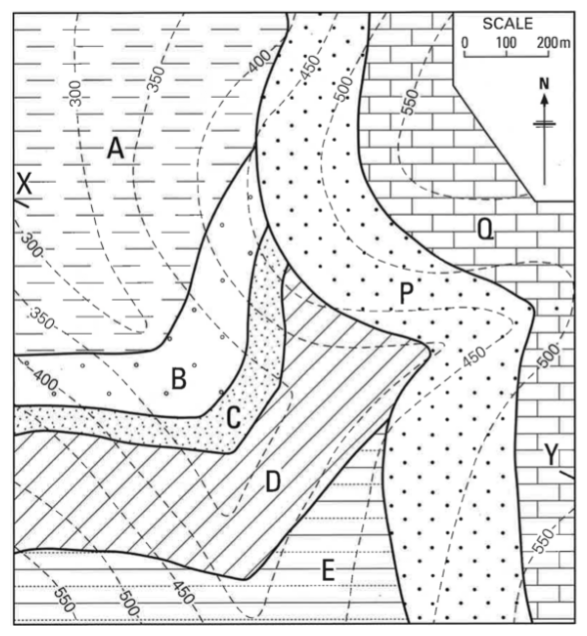

In [2]:
# Display map image
img = mpimg.imread("map2.png")
fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(img)
ax.axis("off");

## 1. Topography

### Read and plot the contours

In [3]:
def df_to_gdf(path, sep):
    """
    Make pandas DataFrame from path to text file
    and convert it to and return geopandas DataFrame
    sep is the separator of the columns in the text file
    """
    df = pd.read_csv(path, sep=sep)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y), crs="EPSG:4326") # use WGS84 projection
    return gdf

In [4]:
# Read the contours.txt file from the contours directory and show its first five lines
topo = df_to_gdf(os.path.join("contours", "contours.txt"), sep="\t")
topo.head()

,X,Y,Z,geometry
0,4.47,954.44,300,POINT (4.47300 954.43900)
1,17.91,929.65,300,POINT (17.90500 929.64900)
2,34.36,908.75,300,POINT (34.35900 908.74900)
3,49.39,887.48,300,POINT (49.39000 887.48300)
4,63.38,871.94,300,POINT (63.38400 871.94000)


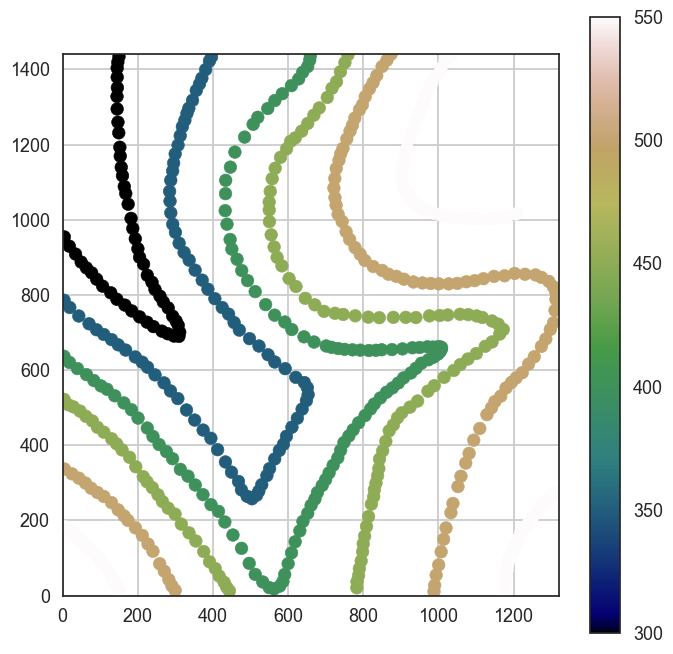

In [5]:
# Plot the contours
fig, ax = plt.subplots(1, figsize=(8, 8))
topo.plot(ax=ax, aspect="equal",column="Z", cmap="gist_earth", legend=True)
ax.set_ylim((0,1440))
ax.set_xlim((0,1320))
ax.grid();

### Interpolate the contour lines to make a digital elevation model (DEM)

In [6]:
# Interpolate contour lines to make DEM
topo_raster = gg.vector.interpolate_raster(gdf=topo,value="Z",method="rbf",res=5)

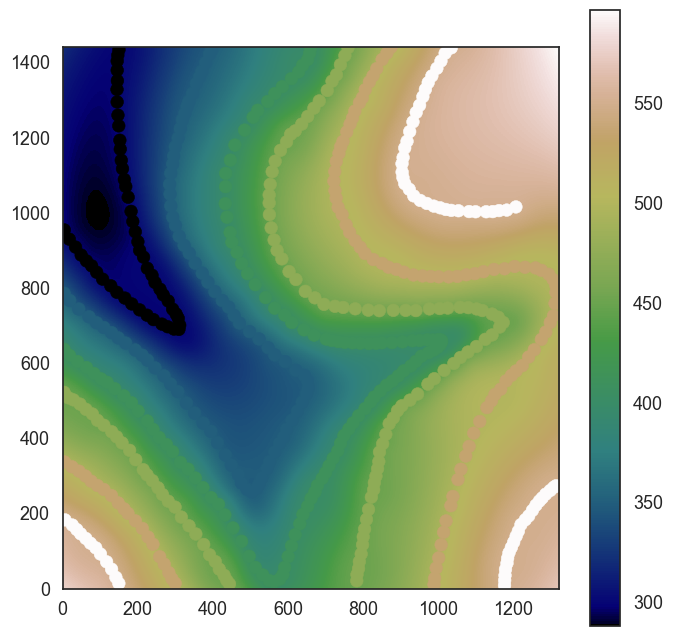

In [7]:
# Plot the DEM
fig, ax = plt.subplots(1, figsize=(8, 8))
topo.plot(ax=ax, aspect="equal", column="Z", cmap="gist_earth")
im = ax.imshow(topo_raster, origin="lower", extent=[0, 1320, 0, 1440], cmap="gist_earth")
cbar = plt.colorbar(im);

In [8]:
# Save the DEM as a tif file
gg.raster.save_as_tiff(raster=topo_raster, path="dem_map2.tif", 
                       extent=[0, 1320, 0, 1440], crs="EPSG:4326", overwrite_file=True)

Raster successfully saved


In [9]:
# Open the DEM from tif file
topo_raster = rasterio.open("dem_map2.tif")

## 2. Stratigraphic boundaries or units' contacts

In [10]:
# Read the contacts. These are the bases of the units
contacts = df_to_gdf(os.path.join("contacts", "contacts.txt"), sep="\t")
contacts.head()

,X,Y,formation,geometry
0,1185.08,278.16,Q,POINT (1185.07900 278.16000)
1,1120.59,808.63,Q,POINT (1120.58900 808.63000)
2,809.94,1218.35,Q,POINT (809.94300 1218.35400)
3,886.08,204.05,P,POINT (886.08100 204.04700)
4,780.50,732.19,P,POINT (780.50400 732.18800)


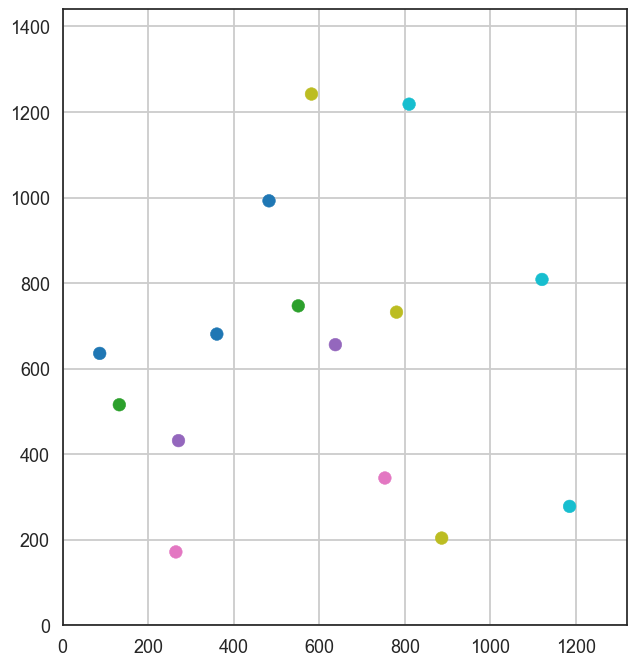

In [11]:
# Plot the points on the contacts in a map view
fig, ax = plt.subplots(1, figsize=(8, 8))
contacts.plot(ax=ax, column="formation", aspect="equal")
ax.set_ylim((0,1440))
ax.set_xlim((0,1320))
ax.grid();

### Extracting Z coordinate

In [12]:
# Extract the Z coordinate of the points at the contacts
contacts_with_Z = gg.vector.extract_xyz(gdf=contacts, dem=topo_raster)
contacts_with_Z.head()

,X,Y,formation,geometry,Z
0,1185.08,278.16,Q,POINT (1185.07900 278.16000),533.29
1,1120.59,808.63,Q,POINT (1120.58900 808.63000),487.89
2,809.94,1218.35,Q,POINT (809.94300 1218.35400),514.53
3,886.08,204.05,P,POINT (886.08100 204.04700),460.82
4,780.50,732.19,P,POINT (780.50400 732.18800),443.64


### Strike lines

In [13]:
# Read the points defining the strike lines on the base of D
gdf_D = df_to_gdf(os.path.join("strike_lines", "strike_lines_D.txt"), sep="\t")
gdf_D.head()

,X,Y,Z,formation,id,geometry
0,396.10,415.08,350,D,1,POINT (396.09700 415.08100)
1,629.59,572.15,350,D,1,POINT (629.58900 572.15400)
2,234.07,436.79,400,D,2,POINT (234.06800 436.78800)
3,638.68,691.00,400,D,2,POINT (638.67700 691.00000)
4,84.33,458.39,450,D,3,POINT (84.32500 458.38700)


In [14]:
# Convert the points into strike lines
linestring_gdf_D = gg.vector.create_linestring_gdf(gdf=gdf_D)
linestring_gdf_D.head()

,index,X,Y,Z,formation,id,geometry
0,0,396.10,415.08,350,D,1,"LINESTRING (396.09700 415.08100, 629.58900 572..."
1,2,234.07,436.79,400,D,2,"LINESTRING (234.06800 436.78800, 638.67700 691..."
2,4,84.33,458.39,450,D,3,"LINESTRING (84.32500 458.38700, 632.19100 809...."


In [15]:
# Check that the strike lines on base D are valid
linestring_gdf_D.is_valid

0    True
1    True
2    True
dtype: bool

In [16]:
# Calculate the orientation of the base of D from the strike lines
orientations_D = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_D)
orientations_D

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,27.56,147.40,375.00,POINT (474.60775 528.75575),1.00,474.61,528.76,D
1,26.81,147.54,425.00,POINT (397.31525 598.82700),1.00,397.32,598.83,D


In [17]:
# Read the points defining the strike lines at the base of B and P
gdf_B = df_to_gdf(os.path.join("strike_lines", "strike_lines_B.txt"), sep="\t")
gdf_P = df_to_gdf(os.path.join("strike_lines", "strike_lines_P.txt"), sep="\t")

In [18]:
# Convert points into strike lines
linestring_gdf_B = gg.vector.create_linestring_gdf(gdf=gdf_B)
linestring_gdf_P = gg.vector.create_linestring_gdf(gdf=gdf_P)

In [19]:
# Check that the strike lines on base B and P are valid
linestring_gdf_B.is_valid

0    True
1    True
dtype: bool

In [20]:
linestring_gdf_P.is_valid

0    True
1    True
dtype: bool

In [21]:
# Calculate orientation of the base of B from strike lines
orientations_B = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_B)
orientations_B.head()

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,27.36,147.28,375.00,POINT (264.62150 745.96525),1.00,264.62,745.97,B


In [22]:
# Calculate orientation of the base of P from strike lines
orientations_P = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_P)
orientations_P.head()

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,17.42,66.23,425.00,POINT (728.81775 986.08250),1.00,728.82,986.08,P


The base of B and the base of D dip 27 degrees to the SE. However, the base of P dips 17 degrees to the NE. The base of P is an unconformity. P and Q lie unconformably over A-E.

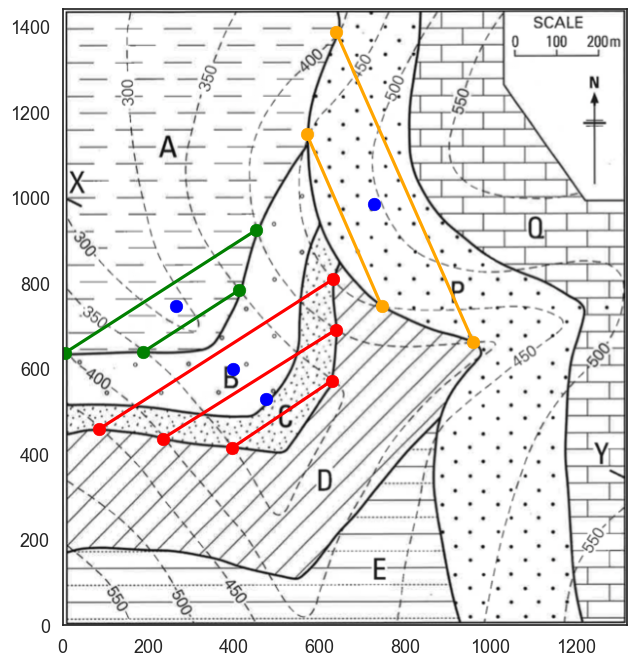

In [23]:
# Plot all this information on the map, the blue dots are orientations
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img, extent=[0, 1320, 0, 1440], cmap="gray")
# base of D
gdf_D.plot(ax=ax, aspect="equal", color="red")
linestring_gdf_D.plot(ax=ax, aspect="equal", color="red")
orientations_D.plot(ax=ax, aspect="equal", color="blue")
# base of B
gdf_B.plot(ax=ax, aspect="equal", color="green")
linestring_gdf_B.plot(ax=ax, aspect="equal", color="green")
orientations_B.plot(ax=ax, aspect="equal", color="blue")
# base of P
gdf_P.plot(ax=ax, aspect="equal", color="orange")
linestring_gdf_P.plot(ax=ax, aspect="equal", color="orange")
orientations_P.plot(ax=ax, aspect="equal", color="blue");

In [24]:
# Merge orientations
orientations = pd.concat([orientations_D, orientations_B,orientations_P]).reset_index()
orientations.head()

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,27.56,147.40,375.00,POINT (474.60775 528.75575),1.00,474.61,528.76,D
1,1,26.81,147.54,425.00,POINT (397.31525 598.82700),1.00,397.32,598.83,D
2,0,27.36,147.28,375.00,POINT (264.62150 745.96525),1.00,264.62,745.97,B
3,0,17.42,66.23,425.00,POINT (728.81775 986.08250),1.00,728.82,986.08,P


## 3. Construction of the model in GemPy

In [25]:
# Create a geomodel object called model2
geo_model = gp.create_model("model2")

In [26]:
# Define model extent, resolution, surface points, and orientations
gp.init_data(geo_model, [0, 1320, 0, 1440, 0, 1000], [100, 100, 100],
             surface_points_df=contacts_with_Z,
             orientations_df=orientations, default_values=True);

Active grids: ['regular']


In [27]:
# Check default series
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Q,Default series,1,#015482,1
1,P,Default series,2,#9f0052,2
2,E,Default series,3,#ffbe00,3
3,D,Default series,4,#728f02,4
4,C,Default series,5,#443988,5
5,B,Default series,6,#ff3f20,6


In [28]:
# The base of the lowermost unit A does not outcrop in the map
# This unit is our "basement", we add it manually
geo_model.add_surfaces("A")

# The units are divided into 2 series
# Strata1 = units above the unconformity
# Strata2 = units below the unconformity
gp.map_stack_to_surfaces(geo_model, {"Strata1": ("Q", "P"), "Strata2": ("E","D", "C", "B", "A"),},
                         remove_unused_series=True)

,surface,series,order_surfaces,color,id
0,Q,Strata1,1,#015482,1
1,P,Strata1,2,#9f0052,2
2,E,Strata2,1,#ffbe00,3
3,D,Strata2,2,#728f02,4
4,C,Strata2,3,#443988,5
5,B,Strata2,4,#ff3f20,6
6,A,Strata2,5,#5DA629,7


In [29]:
# Check the relationships between series
geo_model.stack

,order_series,BottomRelation,isActive,isFault,isFinite
Strata1,1,Erosion,True,False,False
Strata2,2,Erosion,True,False,False


Now we have two different series with their corresponding surfaces. By default, Gempy assigns the unconformity as an erosion.

In [30]:
# Check that the data are correct
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,isBasement,isFault,isActive,hasData,color,vertices,edges,sfai,id,No. of Interfaces,No. of Orientations
0,Q,Strata1,1,False,False,True,True,#015482,NaN,NaN,NaN,1,3,0
1,P,Strata1,2,False,False,True,True,#9f0052,NaN,NaN,NaN,2,3,1
2,E,Strata2,1,False,False,True,True,#ffbe00,NaN,NaN,NaN,3,2,0
3,D,Strata2,2,False,False,True,True,#728f02,NaN,NaN,NaN,4,2,2
4,C,Strata2,3,False,False,True,True,#443988,NaN,NaN,NaN,5,2,0
5,B,Strata2,4,False,False,True,True,#ff3f20,NaN,NaN,NaN,6,3,1
6,A,Strata2,5,True,False,True,True,#5DA629,NaN,NaN,NaN,7,0,0


In [31]:
# Set the topography of the model
geo_model.set_topography(source="gdal",filepath="dem_map2.tif");

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


In [32]:
# Plot the points on the contacts and topography in 3D 
# This will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background",show_topography=True);

In [33]:
# Now we have enough data to interpolate. This may take some time, please wait
gp.set_interpolator(geo_model, compile_theano=True, 
                    theano_optimizer="fast_compile");                    

Setting kriging parameters to their default values.
Compiling aesara function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range             2194.54
$C_o$           114666.67
drift equations    [3, 3]


In [34]:
# Compute the geological model. This may take some time, please wait
gp.compute_model(geo_model);

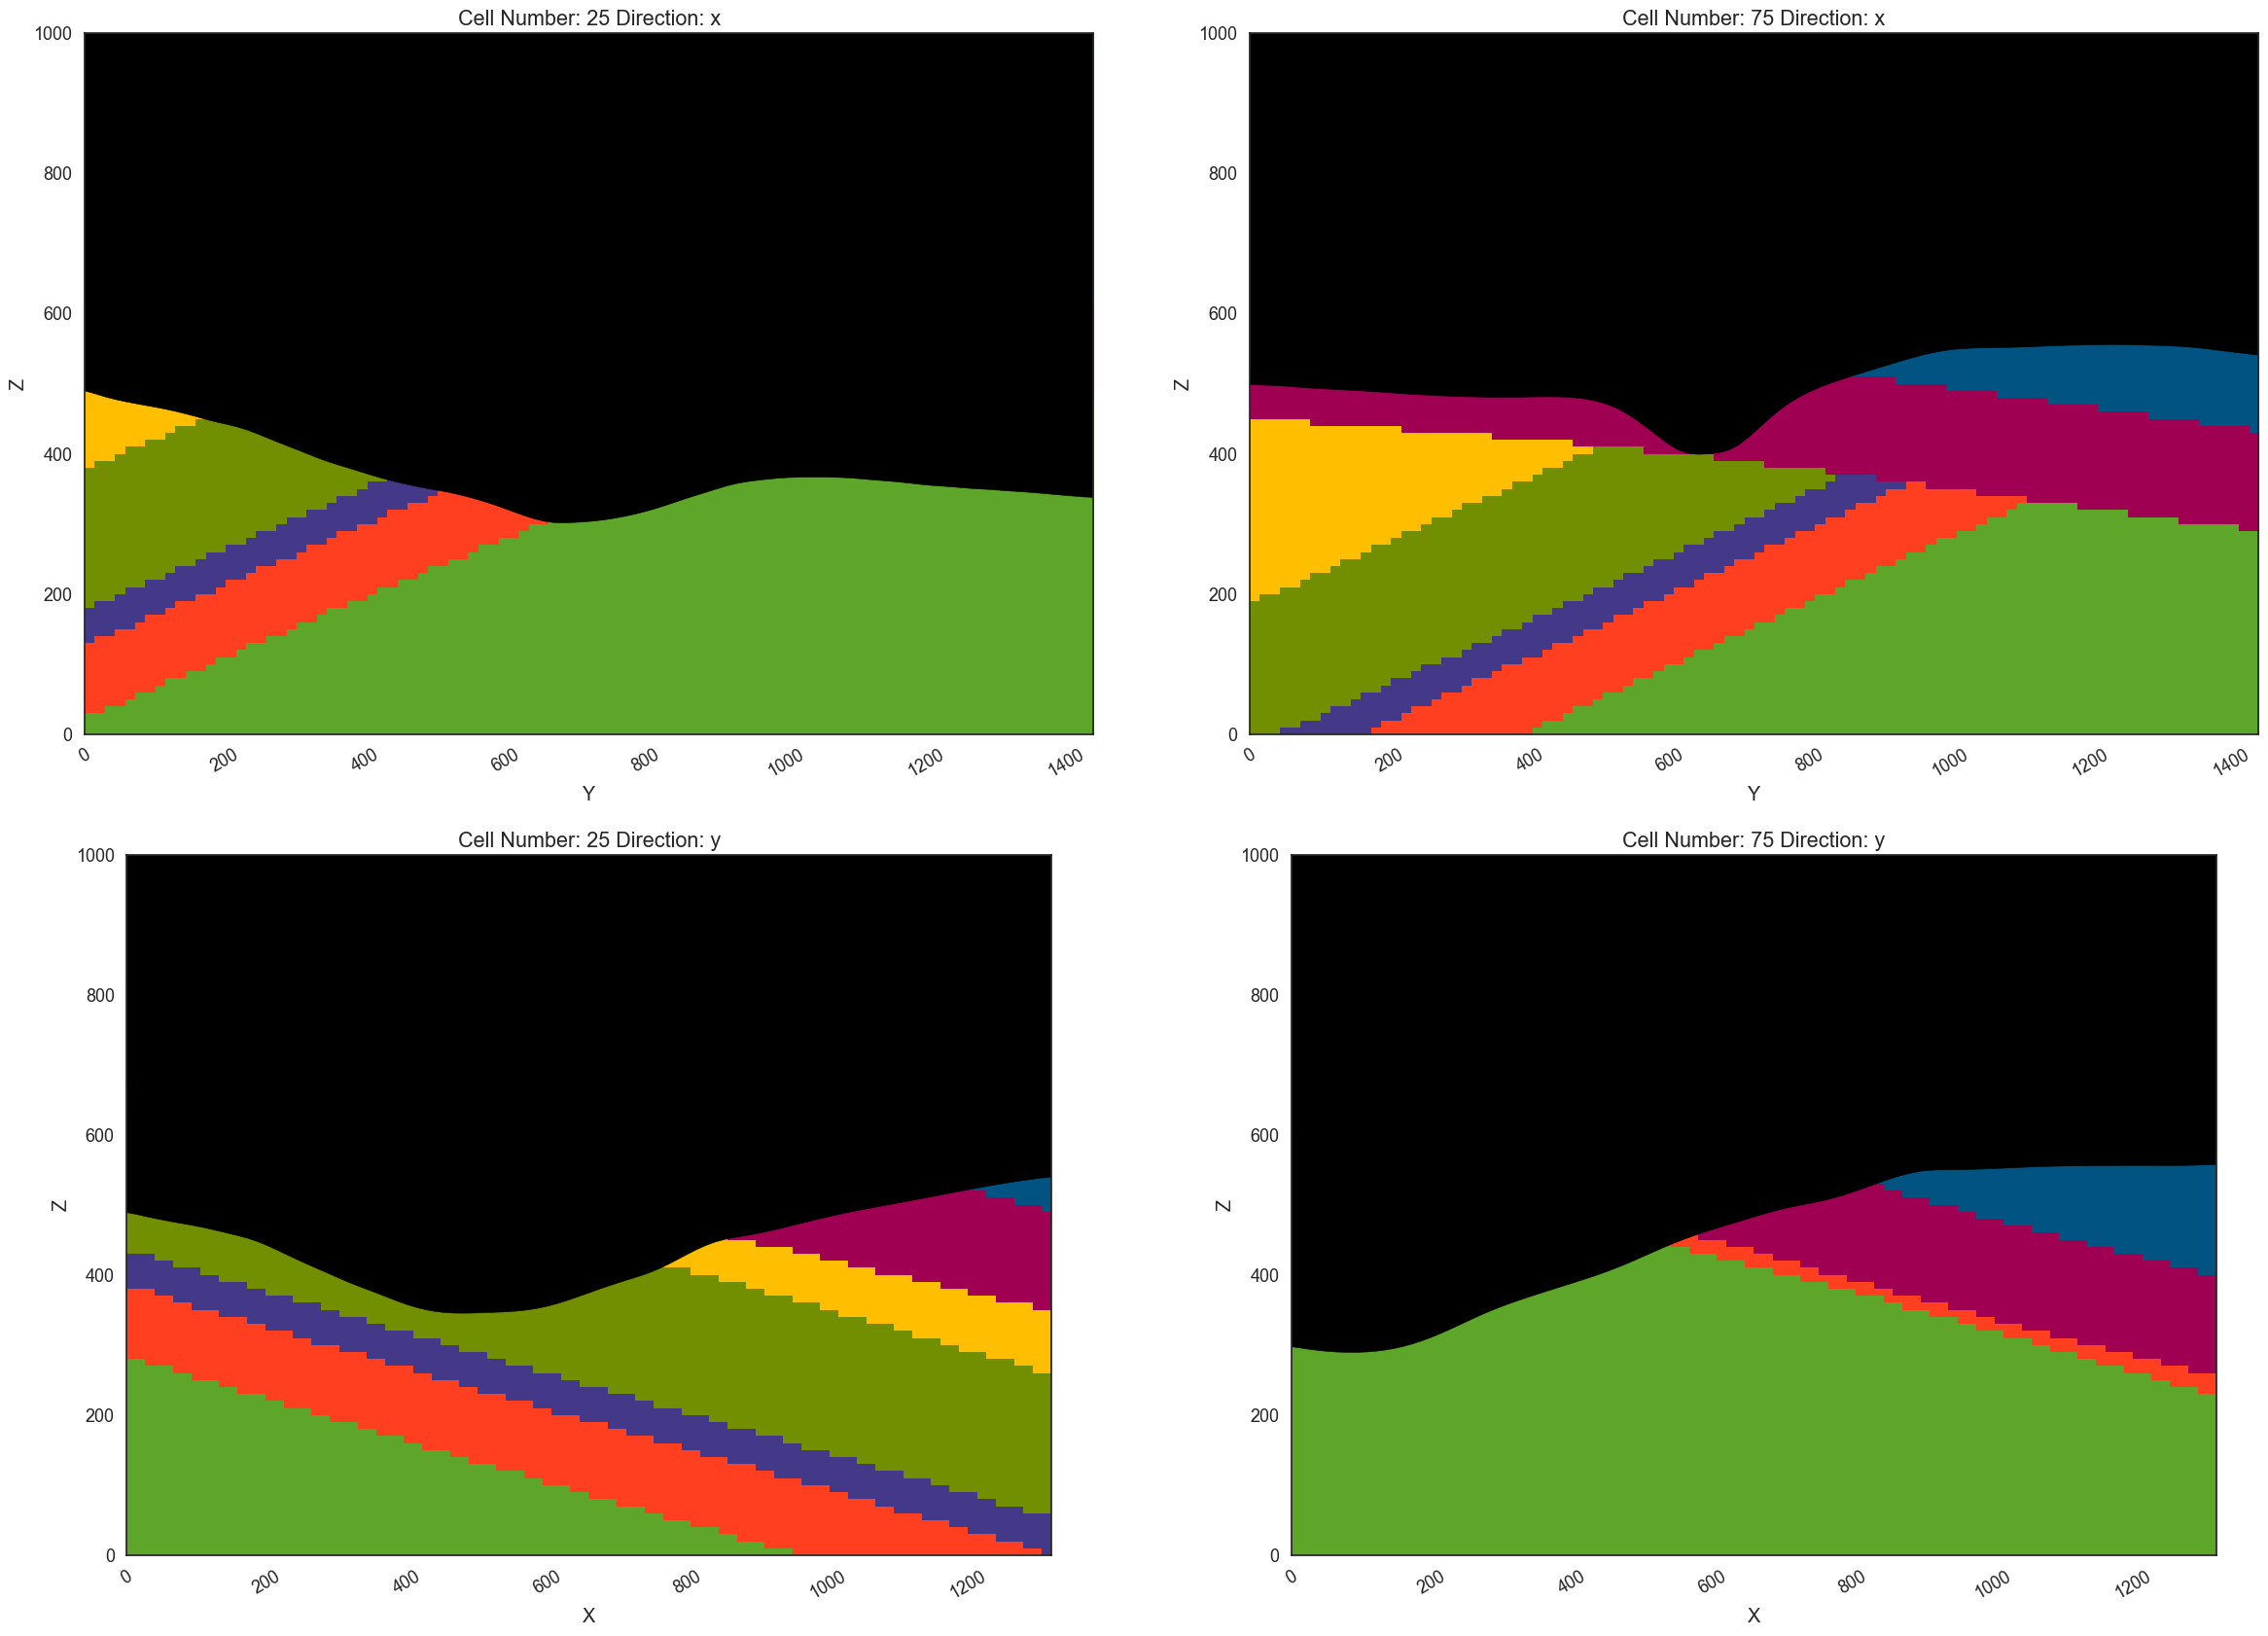

In [35]:
# Plot north-south and east-west sections without vertical exaggeration
gp.plot_2d(geo_model, direction=["x", "x", "y", "y"], cell_number=[25, 75, 25, 75], 
           show_data=False, show_boundaries=False, show_topography=True, show=False);

In [36]:
# Plot the geomodel in 3D, this will open a PyVista window. This may take some time, please wait
gp.plot_3d(geo_model, plotter_type="background", show_topography=True, show_lith=False);

We can clearly see how units Q and P (ids 1 and 2) lie unconformably over units E to A (ids 3 to 7).